In [2]:
import os
import pickle
import shutil
import pandas as pd
import numpy as np
from scipy.stats import mode
from scipy.signal import decimate
from sklearn.preprocessing import MinMaxScaler

In [3]:
MAIN_PATH = os.path.dirname(os.getcwd())
DATA_SUBPATH = '/data'
DATASET_PATH = MAIN_PATH + DATA_SUBPATH + '/unzip/WESAD'
UNPROCESSED_PATH = MAIN_PATH + DATA_SUBPATH + '/unprocessed/WESAD'

In [4]:
TARGET_RATE = 32  # Target rate for processing BVP and ACC
WINDOW_DURATION_SECONDS = 8
SAMPLE_RATE = 700  # Original sample rate for signals
WINDOW_SIZE = WINDOW_DURATION_SECONDS * SAMPLE_RATE  # Total samples in a window
WINDOW_SIZE_32Hz = WINDOW_DURATION_SECONDS * TARGET_RATE  # Total samples for 32 Hz
WINDOW_SIZE_4Hz = WINDOW_DURATION_SECONDS * (TARGET_RATE // 8)  # Total samples for 4 Hz

In [5]:
minfolder = 2
maxfolder = 18
folders = [f'S{i}' for i in range(minfolder, maxfolder)]
print(folders)

['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17']


This process unpacking the zip files can take up to 3 minutes. Depending on the computational power available.

In [5]:
shutil.unpack_archive(MAIN_PATH + DATA_SUBPATH + '/WESAD.zip', MAIN_PATH + DATA_SUBPATH + '/unzip')

KeyboardInterrupt: 

In [6]:
data_folders = []
for subfolder in folders:
    data_folders.append(f"{MAIN_PATH}{DATA_SUBPATH}/unzip/WESAD/{subfolder}/{subfolder}_E4_Data.zip")
print(data_folders)

['c:\\Master of Applied IT/data/unzip/WESAD/S2/S2_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S3/S3_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S4/S4_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S5/S5_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S6/S6_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S7/S7_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S8/S8_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S9/S9_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S10/S10_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S11/S11_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S12/S12_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S13/S13_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S14/S14_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S15/S15_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WESAD/S16/S16_E4_Data.zip', 'c:\\Master of Applied IT/data/unzip/WES

In [6]:
for folder, data_folder in zip(folders, data_folders):
    try:
        shutil.unpack_archive(data_folder, os.path.join(UNPROCESSED_PATH, f'{folder}'))
        print("Preparing folder:", folder)
    except shutil.ReadError:
        print(f"Skipping {data_folder} as it is not a zip file or missing.")

print("Finished unzipping and preparing files.")

Preparing folder: S2
Preparing folder: S3
Preparing folder: S4
Preparing folder: S5
Preparing folder: S6
Preparing folder: S7


KeyboardInterrupt: 

In [7]:
def create_destination_folder(destination_folder, folder):
    """Create the destination folder if it doesn't exist."""
    destination_path = os.path.join(destination_folder, folder)
    os.makedirs(destination_path, exist_ok=True)
    return destination_path

def downsample_signal_with_filter(signal, original_rate, target_rate):
    """Downsample a signal with anti-aliasing filter using scipy's decimate."""
    decimation_factor = original_rate // target_rate
    if decimation_factor > 1:
        return decimate(signal, decimation_factor, zero_phase=True)
    return signal

def downsample_labels(labels, original_rate, target_rate):
    """Downsample labels using mode filtering."""
    decimation_factor = (original_rate // target_rate)
    print(f'decimation_factor: {decimation_factor}')

    downsampled_labels = []
    for i in range(0, len(labels), decimation_factor):
        segment = labels[i:i + decimation_factor]
        mode_value, _ = mode(segment)  # Extract mode value
        downsampled_labels.append(mode_value)
        
    return np.array(downsampled_labels)




In [8]:
def scale_signals(*signals):
    """Scale multiple signals using MinMaxScaler."""
    scaler = MinMaxScaler()
    return [scaler.fit_transform(signal.reshape(-1, 1)).flatten() for signal in signals]

def encode_labels(labels):
    """Encode labels: 1 if label is 2, else 0."""
    return np.where(labels == 2, 1, 0)

def sliding_window(arr, window_size, step_size):
    """Generate non-overlapping windows for a 1D numpy array."""
    return [np.array(arr[i:i + window_size]) for i in range(0, len(arr) - window_size + 1, step_size)]

# Majority vote for labels in each window
def majority_vote(label_window):
    label_counts = np.bincount(label_window)
    return np.argmax(label_counts)

def apply_sliding_window_to_signals(signals, window_sizes):
    windowed_signals = {}
    
    for signal_name, signal_data in signals.items():
        # Use the provided window size for each signal
        window_size = window_sizes.get(signal_name, len(signal_data))
        windowed_signals[signal_name] = sliding_window(signal_data, window_size, window_size)
        
        # Print statements for debugging and tracking
        print(f"Applied sliding window to signal: {signal_name}, Window size: {window_size}, "
              f"Number of windows: {len(windowed_signals[signal_name])}")

    return windowed_signals


In [19]:
WINDOW_SIZES = {'32Hz': 256, '4Hz': 32}  
TARGET_FREQS = {'ACC': '32Hz', 'BVP': '32Hz', 'EDA': '4Hz', 'TEMP': '4Hz'}

def process_wrist_signals(folder):
    """Process wrist signals, apply non-overlapping sliding window, and save to CSV."""
    
    # Define paths
    print("Creating destination path for wrist data.")
    destination_path = create_destination_folder(UNPROCESSED_PATH, f'{folder}/wrist')
    source_path = os.path.join(DATASET_PATH, folder, f'{folder}.pkl')
    print(f"Source path set to: {source_path}")
    
    # Check if source file exists
    if not os.path.exists(source_path):
        print(f"Skipping {source_path} as it does not exist.")
        return
    
    # Load data
    print("Loading data from source file.")
    with open(source_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
          
        # Extract wrist signals and labels
        print("Extracting wrist signals.")
        signals = data['signal']['wrist']
        wrist_data = {
            'ACC_X': signals['ACC'][:, 0].astype(np.float64),  # ACC x-axis
            'ACC_Y': signals['ACC'][:, 1].astype(np.float64),  # ACC y-axis
            'ACC_Z': signals['ACC'][:, 2].astype(np.float64),  # ACC z-axis
            'BVP': signals['BVP'][:, 0],  # BVP at 64 Hz, will be resampled
            'EDA': signals['EDA'][:, 0],   # EDA at 4 Hz
            'TEMP': signals['TEMP'][:, 0]  # TEMP at 4 Hz
        }
        labels = data['label']
        print("Signals extracted.")

        # Downsample labels from 700 Hz to 4 Hz. And encode labels.
        print("Downsampling & Encoding labels.")
        downsampled_labels = downsample_labels(labels, SAMPLE_RATE, 4)
        encoded_labels = encode_labels(downsampled_labels)

        # Resample BVP to 32Hz (64 Hz to 32 Hz)
        wrist_data['BVP'] = downsample_signal_with_filter(wrist_data['BVP'], 64, TARGET_RATE)
        
        # Normalize wrist signals before creating sliding windows
        print("Normalizing wrist signals.")
        normalized_data = {key: scale_signals(signal)[0] for key, signal in wrist_data.items()}
        print("Normalization applied.")
        
        # Apply sliding windows dynamically based on frequency
        print("Applying sliding windows to each signal.")
        windows = {}
        for key, signal in normalized_data.items():
            target_freq = TARGET_FREQS.get(key.split('_')[0], '32Hz')
            window_size = WINDOW_SIZES[target_freq]
            windows[key] = sliding_window(signal, window_size, window_size)
            
        # Apply sliding window to labels at 4Hz
        windows_labels = sliding_window(encoded_labels, WINDOW_SIZES['4Hz'], WINDOW_SIZES['4Hz'])
        print("Sliding windows applied.")

        # Process each window with majority voting on labels
        print("Aggregating labels with majority voting.")
        majority_labels = [majority_vote(window) for window in windows_labels]

        # Combine windows into a DataFrame
        print("Combining windows into a DataFrame.")
        all_windows = [
            {
                **{key: f"[{', '.join(map(str, windows[key][i]))}]" for key in windows},
                "labels": majority_labels [i],
                "ID": folder,
                "StartTime": i * WINDOW_DURATION_SECONDS  # Start time for each non-overlapping window
            }
            for i in range(len(windows['ACC_X']))  # Length based on primary frequency window (32Hz for ACC)
        ]
        df_windows = pd.DataFrame(all_windows)
        print("DataFrame created with sliding windows.")

        # Save the DataFrame as a CSV file
        csv_path_wrist = os.path.join(destination_path, f'{folder}.csv')
        df_windows.to_csv(csv_path_wrist, index=False)
        print(f"Saved wrist data with sliding windows to: {csv_path_wrist}")

        return df_windows
    
s2 = process_wrist_signals('S2')

Creating destination path for wrist data.
Source path set to: c:\Master of Applied IT/data/unzip/WESAD\S2\S2.pkl
Loading data from source file.
Extracting wrist signals.
Signals extracted.
Downsampling & Encoding labels.
decimation_factor: 175
Normalizing wrist signals.
Normalization applied.
Applying sliding windows to each signal.
Sliding windows applied.
Aggregating labels with majority voting.
Combining windows into a DataFrame.
DataFrame created with sliding windows.
Saved wrist data with sliding windows to: c:\Master of Applied IT/data/unprocessed/WESAD\S2/wrist\S2.csv


In [15]:
def process_chest_signals(folder):
    """Process chest signals at 700 Hz, apply 700-sample sliding window, and save to CSV."""
    
    # Define paths
    print("Creating destination path for chest data.")
    destination_path = create_destination_folder(UNPROCESSED_PATH, f'{folder}/chest')
    source_path = os.path.join(DATASET_PATH, folder, f'{folder}.pkl')
    print(f"Source path set to: {source_path}")
    
    # Check if source file exists
    if not os.path.exists(source_path):
        print(f"Skipping {source_path} as it does not exist.")
        return

    # Load data
    print("Loading data from source file.")
    with open(source_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')

    # Extract chest signals and labels
    signals = data['signal']['chest']
    labels = data['label']
    print("Data loaded. Extracting individual signals.")
    
    # Extract individual signals
    chest_signals = {
        'ecg': signals['ECG'][:, 0],
        'eda': signals['EDA'][:, 0],
        'emg': signals['EMG'][:, 0],
        'temp': signals['Temp'][:, 0],
        'resp': signals['Resp'][:, 0],
        'acc': signals['ACC'][:, 0]  # Use only one axis if ACC is multi-dimensional
    }
    print("Signals extracted:", list(chest_signals.keys()))

    # Encode labels
    print("Encoding labels.")
    encoded_labels = encode_labels(labels)
    chest_signals['labels'] = encoded_labels
    print("Labels encoded.")

    # Normalize each signal (except labels)
    print("Applying normalization to signals.")
    normalized_signals = scale_signals(*[chest_signals[key] for key in chest_signals if key != 'labels'])
    for i, key in enumerate([k for k in chest_signals if k != 'labels']):
        chest_signals[key] = normalized_signals[i]
    print("Normalization applied.")

    # Set window sizes for each signal to 700 samples (no downsampling)
    window_sizes = {signal: SAMPLE_RATE for signal in chest_signals.keys()}

    # Apply sliding windows to each signal
    print("Applying sliding windows to each signal.")
    chest_windows = apply_sliding_window_to_signals(chest_signals, window_sizes)
    print("Sliding windows applied.")

    # Combine windows into a DataFrame
    print("Combining windows into a DataFrame.")
    all_windows = [
        {
            "ECG": f"[{', '.join(map(str, chest_windows['ecg'][i]))}]",
            "EDA": f"[{', '.join(map(str, chest_windows['eda'][i]))}]",
            "EMG": f"[{', '.join(map(str, chest_windows['emg'][i]))}]",
            "Temp": f"[{', '.join(map(str, chest_windows['temp'][i]))}]",
            "Resp": f"[{', '.join(map(str, chest_windows['resp'][i]))}]",
            "ACC": f"[{', '.join(map(str, chest_windows['acc'][i]))}]",
            "labels": f"[{', '.join(map(str, chest_windows['labels'][i]))}]",
            "ID": folder,
            "StartTime": i * WINDOW_DURATION_SECONDS  # Start time for each window
        }
        for i in range(len(chest_windows['ecg']))
    ]
    df_windows = pd.DataFrame(all_windows)
    print("DataFrame created with sliding windows.")

    # Save the DataFrame as a CSV file
    csv_path_chest = os.path.join(destination_path, f'{folder}.csv')
    df_windows.to_csv(csv_path_chest, index=False)
    print(f"Saved chest data with sliding windows to: {csv_path_chest}")

    return df_windows


Creating destination path for wrist data.
Source path set to: c:\Master of Applied IT/data/unzip/WESAD\S2\S2.pkl
Loading data from source file.
Extracting wrist signals.
Signals extracted.
Downsampling & Encoding labels.
decimation_factor: 175
Normalizing wrist signals.
Normalization applied.
Applying sliding windows to each signal.
Sliding windows applied.
Aggregating labels with majority voting.
Combining windows into a DataFrame.
DataFrame created with sliding windows.
Saved wrist data with sliding windows to: c:\Master of Applied IT/data/unprocessed/WESAD\S2/wrist\S2.csv


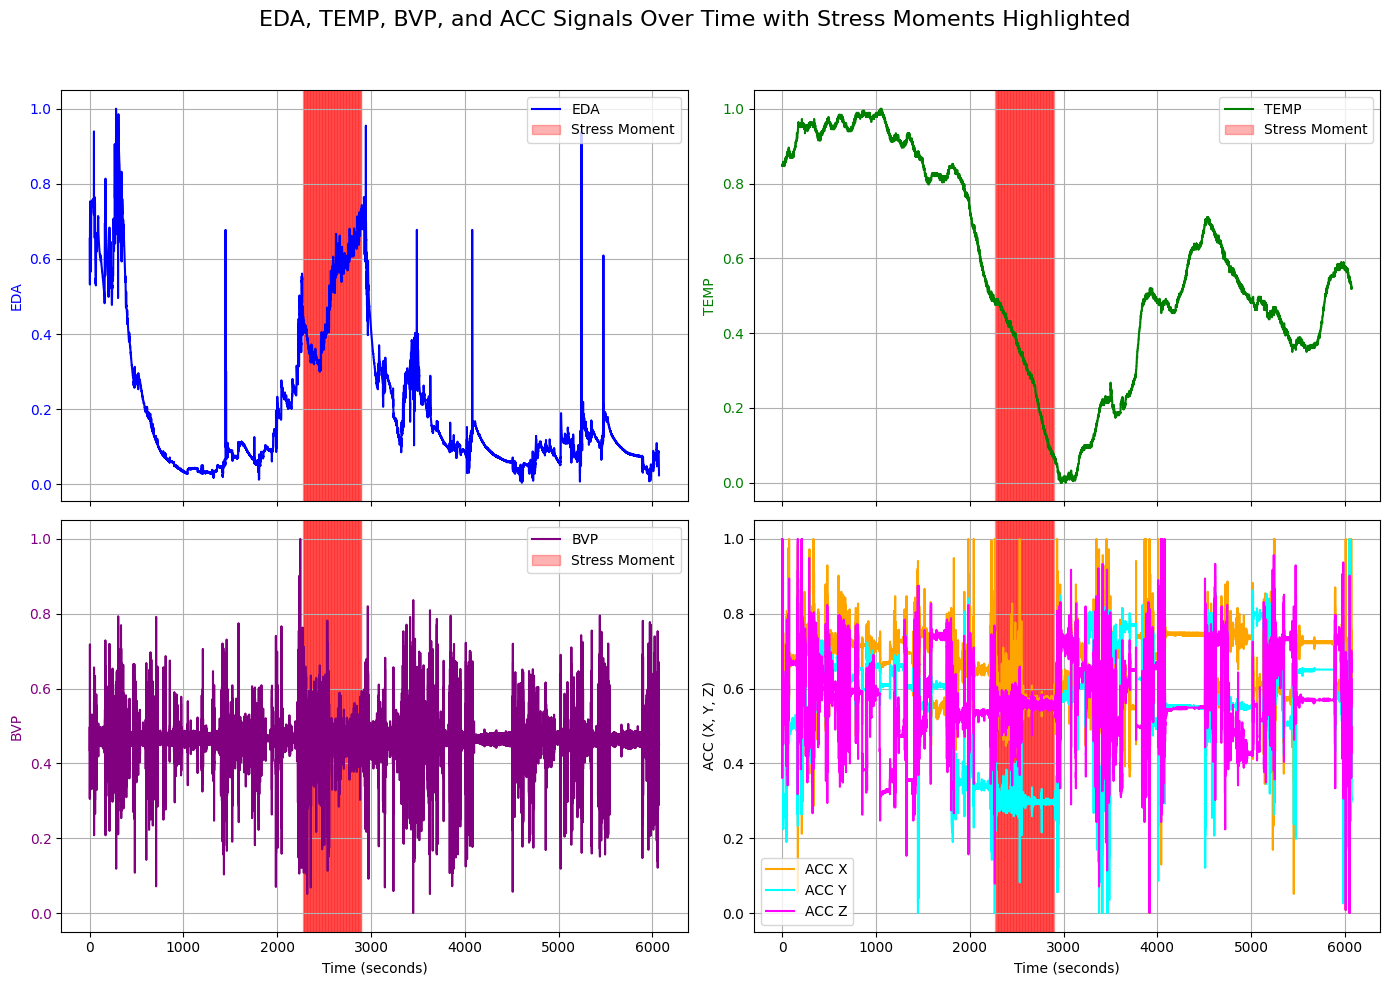

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_signal_with_highlight(ax, time, signal, stress_indices, df, title, color, ylabel):
    """Helper function to plot a signal with stress highlights."""
    ax.plot(time, signal, label=title, color=color)
    ax.set_ylabel(ylabel, color=color)
    ax.tick_params(axis='y', labelcolor=color)
    
    # Highlight stress moments
    for idx in stress_indices:
        ax.axvspan(df['StartTime'][idx], df['StartTime'][idx] + 8, color='red', alpha=0.3, label='Stress Moment' if idx == stress_indices[0] else "")

def plot_windows_signals(folder_path):
    """Plots the EDA, TEMP, BVP, and ACC (X, Y, Z) windows and highlights stress moments."""
    # Load the CSV file
    csv_file = os.path.join(folder_path, 'S2_sliding_windows.csv')
    df = pd.read_csv(csv_file)

    # Convert string representations to numpy arrays
    def convert_to_array(series):
        return series.apply(lambda x: np.fromstring(x.strip('[]'), sep=',') if isinstance(x, str) else np.nan)

    eda_windows = convert_to_array(df['EDA'])
    temp_windows = convert_to_array(df['TEMP'])
    bvp_windows = convert_to_array(df['BVP'])
    x_windows = convert_to_array(df['X'])
    y_windows = convert_to_array(df['Y'])
    z_windows = convert_to_array(df['Z'])

    # Flatten the arrays for plotting
    flat_eda = np.concatenate(eda_windows.values)
    flat_temp = np.concatenate(temp_windows.values)
    flat_bvp = np.concatenate(bvp_windows.values)
    flat_x = np.concatenate(x_windows.values)
    flat_y = np.concatenate(y_windows.values)
    flat_z = np.concatenate(z_windows.values)

    # Calculate time for the x-axis
    time_axis_eda = np.arange(0, len(flat_eda)) / 4  # EDA is sampled at 4 Hz
    time_axis_temp = np.arange(0, len(flat_temp)) / 4  # TEMP is sampled at 4 Hz
    time_axis_bvp = np.arange(0, len(flat_bvp)) / 32  # BVP is sampled at 32 Hz
    time_axis_acc = np.arange(0, len(flat_x)) / 32  # ACC is sampled at 32 Hz

    # Identify stress moments (label = 2)
    stress_indices = df[df['labels'].apply(lambda x: 1 in eval(x) if isinstance(x, str) else False)].index

    # Create the subplots with 2 columns
    fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    axs = axs.flatten()  # Flatten the 2D array of axes for easy indexing

    # Plot EDA
    plot_signal_with_highlight(axs[0], time_axis_eda, flat_eda, stress_indices, df, 'EDA', 'blue', 'EDA')

    # Plot TEMP
    plot_signal_with_highlight(axs[1], time_axis_temp, flat_temp, stress_indices, df, 'TEMP', 'green', 'TEMP')

    # Plot BVP
    plot_signal_with_highlight(axs[2], time_axis_bvp, flat_bvp, stress_indices, df, 'BVP', 'purple', 'BVP')

    # Plot ACC (X, Y, Z)
    axs[3].plot(time_axis_acc, flat_x, label='ACC X', color='orange')
    axs[3].plot(time_axis_acc, flat_y, label='ACC Y', color='cyan')
    axs[3].plot(time_axis_acc, flat_z, label='ACC Z', color='magenta')
    axs[3].set_ylabel('ACC (X, Y, Z)')
    axs[3].tick_params(axis='y')

    # Highlight stress moments for ACC
    for idx in stress_indices:
        axs[3].axvspan(df['StartTime'][idx], df['StartTime'][idx] + 8, color='red', alpha=0.3)

    # Adding X-axis label and grid
    axs[2].set_xlabel('Time (seconds)')
    axs[3].set_xlabel('Time (seconds)')
    for ax in axs:
        ax.grid()

    # Show legends for each plot
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    axs[3].legend()

    # Set title for the entire figure
    plt.suptitle('EDA, TEMP, BVP, and ACC Signals Over Time with Stress Moments Highlighted', fontsize=16)

    # Show the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust top to fit the title
    plt.show()
    
# Example call to plot the EDA, TEMP, BVP, and ACC windows with stress moments highlighted
folder_path = MAIN_PATH + r'/data\unprocessed\WESAD\S2\wrist'  # Adjust the path as necessary
plot_windows_signals(folder_path)


In [12]:
# Iterate over the folders and process wrist and chest signals
for folder in folders:
    try:
        process_wrist_signals(folder)
        # process_chest_signals(folder)
    except pickle.UnpicklingError:
        print(f"Skipping {folder} due to unpickling error.")


Creating destination path for wrist data.
Source path set to: c:\Master of Applied IT/data/unzip/WESAD\S2\S2.pkl
Loading data from source file.
Extracting wrist signals.
Signals extracted.
Downsampling & Encoding labels.
decimation_factor: 175
Normalizing wrist signals.
Normalization applied.
Applying sliding windows to each signal.
Sliding windows applied.
Aggregating labels with majority voting.
Combining windows into a DataFrame.
DataFrame created with sliding windows.
Saved wrist data with sliding windows to: c:\Master of Applied IT/data/unprocessed/WESAD\S2/wrist\S2.csv
Creating destination path for wrist data.
Source path set to: c:\Master of Applied IT/data/unzip/WESAD\S3\S3.pkl
Loading data from source file.
Extracting wrist signals.
Signals extracted.
Downsampling & Encoding labels.
decimation_factor: 175
Normalizing wrist signals.
Normalization applied.
Applying sliding windows to each signal.
Sliding windows applied.
Aggregating labels with majority voting.
Combining windows

KeyboardInterrupt: 

In [24]:
# Create an empty DataFrame to store the merged data
merged_df = pd.DataFrame()

# Loop through the folders and merge the S-subject.csv files
for folder in folders:
    file_path = os.path.join(MAIN_PATH + DATA_SUBPATH,'unprocessed', 'WESAD', folder, f'{folder}.csv')
    if not os.path.exists(file_path):
        print("Document does not exist:", file_path)
        continue
    df = pd.read_csv(file_path)
    merged_df = pd.concat([merged_df, df], ignore_index=True)

# Save the merged DataFrame as a CSV file
merged_file_path = os.path.join(MAIN_PATH + DATA_SUBPATH, 'merged_data.csv')
merged_df.to_csv(merged_file_path, index=False)

print("Merged data saved as:", merged_file_path)


Wrist file does not exist: c:\Master of Applied IT/data/unprocessed/WESAD\S12\wrist\S12.csv
Chest file does not exist: c:\Master of Applied IT/data/unprocessed/WESAD\S12\chest\S12.csv
Merged wrist data saved as: c:\Master of Applied IT/data\wrist_merged_data.csv


KeyboardInterrupt: 